In [1]:
%matplotlib inline

#%matplotlib 
#import matplotlib.pyplot as plt
#plt.ion()

In [2]:
%load_ext autoreload
%autoreload 2

In [48]:
import os
import torch
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D, lineMarkers
import seaborn as sns
sns.set_style('darkgrid')
import scipy
from scipy import special as s
from scipy.optimize import minimize
import pandas as pd
import numpy
import math
from time import time

from mpl_toolkits.mplot3d import Axes3D

In [ ]:
lineMarkers()

In [4]:
cwd = os.getcwd()
NOTEBOOK_DIR = os.path.dirname(cwd+'/')
ROOT = os.path.dirname(NOTEBOOK_DIR)

import sys
sys.path.append(ROOT)

In [5]:
from utils.plot import *
from utils.tools import *
from utils.nn import TARGET_FUNCS_DICT, LOSS_DICT
from networks import linear_net

## Constants

In [6]:
n_samples = 100 # 500
input_dim = 60 # 50
width = 20 # 1024  # 1024
bias = False
base_lr = 1.0e-2
batch_size = 512

SEED = 42
n_steps = 10*int(1e3) # 5*int(1e4) # int(5e3) # 20000
n_trials = 10 # 10

#widths = [10, 20, 50, 128, 256, 1024]
# widths = [10, 50, 128, 1024]
# widths = [10, 50, 100, 512]
widths = [1024]
alpha_init = 1.0

In [7]:
FIGURES_DIR = os.path.join(ROOT, 'figures/2-layer/linear-net/')
create_dir(FIGURES_DIR)

In [8]:
set_random_seeds(SEED)

## Model

$\mathbb{P}$ is the empirical distribution $\mathbb{P} = \frac{1}{n} \sum_{i=1}^n \delta_{x_i}$, where $x_i \sim \mathcal{U}([-1, 1]^d)  =: P_x$.

 \begin{align*}
    f^*(x) &= C_d \sum_{k=1}^d z^\star_k x_k^3 \\
    z^\star &\sim \mathcal{U}(\mathbb{S}^{d-1}) \\
    C_d :&= \sqrt{7}
\end{align*}
with $C_d$ calibrated such that $\frac{1}{2}\mathbb{E}_{P_x}[f^*(x)^2] = 1$. 

Because $n=100 > 60=d$, and the $x_i$ are drawn uniformly, $X = [x_1; \ldots; x_n]^\top$ is full-rank and the least square problem $Q$ has a unique minimizer.

## Data & Net

In [9]:
# val & train data
X_val = 2 * torch.rand(size=(n_samples, input_dim), requires_grad=False) - 1
X_train = 2 * torch.rand(size=(n_samples, input_dim), requires_grad=False) - 1

z_star_gauss = torch.randn(size=(input_dim, 1), requires_grad=False)
z_star = z_star_gauss / torch.linalg.norm(z_star_gauss, ord=2, keepdims=False)

# C_d
#norm_z_star = torch.linalg.norm(z_star, ord=2, keepdims=False)
#C = np.sqrt((input_dim**3) * 2 / 15) / norm_z_star
C = np.sqrt(7)

#y_val = torch.sinh(torch.matmul(X_val, w_star) / np.sqrt(input_dim))
#all_ys = torch.sinh(torch.matmul(all_Xs, w_star)  / np.sqrt(input_dim))
y_val = C * torch.matmul(X_val**3, z_star)
#y_train = C * torch.matmul(X_train**3, z_star)
y_train = torch.randn(size=(1,), requires_grad=False) + \
          np.sqrt(2) * torch.randn(size=(n_samples, 1), requires_grad=False)

w_star = torch.linalg.lstsq(input=X_train, b=y_train).solution
global_min = (torch.linalg.norm(y_train - torch.matmul(X_train, w_star), ord=2, keepdims=False)**2).item() /\
             (2*n_samples)

lambda_min = torch.min(torch.real(torch.linalg.eigvals(np.matmul(X_train.t(), X_train)))).item()

#w_star = (np.sqrt(6 * input_dim / 5) * z_star / norm_z_star).detach().numpy().reshape(-1)
#norm_w_star = np.linalg.norm(w_star)
#w_star_normalized = w_star / norm_w_star

In [10]:
networks = {i: {width: linear_net.LinearNet(input_dim=input_dim, width=width, bias=bias) 
                for width in widths}
            for i in range(n_trials)}
for dic in networks.values():
    for network in dic.values():
        network.train()
        with torch.no_grad():
            network.input_layer.weight.data.copy_(alpha_init * network.input_layer.weight.detach().data)
optimizers = {i: {width: torch.optim.SGD(networks[i][width].parameters(), lr=width * base_lr) 
                  for width in widths}
              for i in range(n_trials)}

## Training dynamics

In [11]:
def train(network, optimizer):
    train_losses = []
    val_losses = []
    y_hat_vals = []
    #ws = [np.zeros(input_dim)]
    with torch.no_grad():
        ws_m = 0.5 * network.input_layer.weight.detach() * \
                         torch.transpose(network.output_layer.weight.detach(), 0, 1)
        ws = [np.mean(ws_m.numpy(), axis=0)]
    with torch.no_grad():
        as_squared = [np.mean(network.output_layer.weight.detach().numpy().reshape(-1) **2 )] 

    for i in range(n_steps):
        optimizer.zero_grad()

        # forward
        y_hat = network.forward(X_train)
        loss_ = 0.5 * ((y_hat - y_train) ** 2).mean()

        # backward and gradient step
        loss_.backward()
        optimizer.step()
        train_losses.append(loss_.detach().item())

        # val
        with torch.no_grad():
            y_hat_val = network.forward(X_val)
            val_loss = 0.5 * ((y_hat_val - y_val) ** 2).mean()
            val_losses.append(val_loss.detach().item())
            y_hat_vals.append(y_hat_val.detach().numpy())

            ws_m = 0.5 * network.input_layer.weight.detach() * \
                         torch.transpose(network.output_layer.weight.detach(), 0, 1)
            ws.append(np.mean(ws_m.numpy(), axis=0))
            
            as_squared.append(np.mean(network.output_layer.weight.detach().numpy().reshape(-1) **2 ))
            

    train_losses = np.array(train_losses)
    val_losses = np.array(val_losses)
    y_hat_vals = np.array(y_hat_vals)
    ws = np.array(ws)
    as_squared = np.array(as_squared)

    #norm_ws = np.linalg.norm(ws, ord=2, axis=1, keepdims=True)
    #ws_normalized = ws[1:, :] / norm_ws[1:, :]
    
    return {'train_losses': train_losses,
            'val_losses': val_losses, 
            'y_hat_vals': y_hat_vals,
            'ws': ws,
            'as_squared': as_squared}
            #'ws_normalized': ws_normalized}

In [12]:
start = time()
training_results = {i: dict() for i in range(n_trials)}
for i in range(n_trials):
    for width in widths:
        training_results[i][width] = train(networks[i][width], optimizers[i][width])
end = time()

#ws = training_results[width]['ws']
print('Run time : {:.2f} minutes'.format((end - start) / 60))

Run time : 6.41 minutes


## Plots

In [13]:
data_frames = []
for i in range(n_trials):
    for width in widths:
        data_ = pd.DataFrame(columns=['trial', 'width', '$t$', 'training_loss'])
        data_['training_loss'] = training_results[i][width]['train_losses']
        data_['trial'] = i
        data_['width'] = width
        data_['$t$'] = np.arange(len(training_results[i][width]['train_losses']))
        
        data_frames.append(data_)
        
data = pd.concat(data_frames, axis=0, ignore_index=True)
agg_df = data.groupby(by=['width', '$t$']).agg({'training_loss' : [np.min, np.max, np.mean]})
df = agg_df.reset_index(level=[0, 1])

df = pd.concat([df[['width', '$t$']], df['training_loss']], axis=1)
df.columns = ['width', '$t$', 'min', 'max', 'mean']

# df.head()

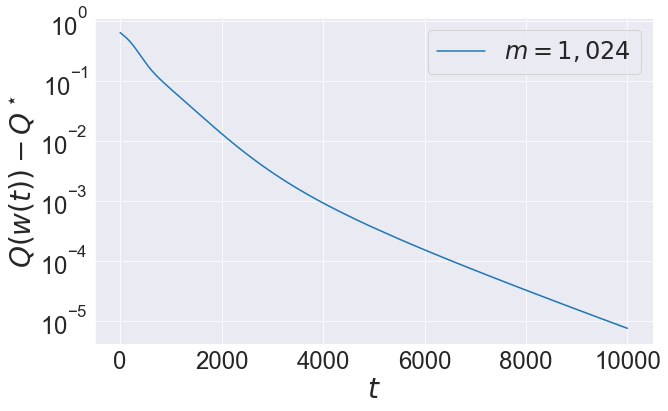

In [14]:
df_by_width = df.groupby('width')
plt.figure(figsize=(10, 6))
plt.yscale('log')
for width, df_width in df_by_width:
    plt.plot(df_width['$t$'].values, df_width['mean'].values - global_min, label='$m={:,}$'.format(width))
    plt.fill_between(df_width['$t$'].values, df_width['min'].values  - global_min, 
                     df_width['max'].values - global_min, alpha=0.2)

#plt.plot(np.arange(n_steps), [np.exp(-2 * base_lr * lambda_min * t) for t in np.arange(n_steps)], linewidth=2.0, 
#         label='$e^{-2 \eta \lambda_{min} t}$', color='black')
plt.xlabel('$t$', fontsize=28)
plt.ylabel('$Q(w(t)) - Q^\star$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=24)
plt.show()

In [15]:
# SIMPLE GD on Q

lin_w = torch.nn.Linear(in_features=input_dim, out_features=1, bias=False)
with torch.no_grad():
    # re-initialize weights to 0
    lin_w.weight.data.copy_(torch.zeros_like(lin_w.weight))
opt = torch.optim.SGD(lin_w.parameters(), lr=base_lr)

lin_train_losses = []    
ws_lin = [np.zeros(input_dim)]

for i in range(n_steps):
    opt.zero_grad()

    # forward
    y_hat = lin_w.forward(X_train)
    loss_ = 0.5 * ((y_hat - y_train) ** 2).mean()

    # backward and gradient step
    loss_.backward()
    opt.step()
    lin_train_losses.append(loss_.detach().item())

    # val
    with torch.no_grad():
        ws_lin.append(lin_w.weight.detach().numpy().reshape(-1).copy())


lin_train_losses = np.array(lin_train_losses)
ws_lin = np.array(ws_lin)

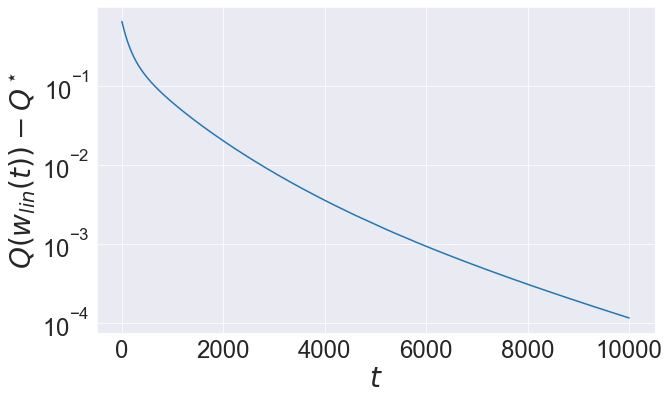

In [16]:
figure = plt.figure(figsize=(10, 6))

#plt.plot(np.arange(n_steps), np.exp(-lambda_min * base_lr * np.arange(n_steps) / 4), 
#         label='upper bound', color='black', linestyle='dashed', linewidth=1.5)   
#plt.plot(np.arange(n_steps), [global_min]*n_steps, label='global minimum', color='darkgrey', linestyle='dashed', 
#         linewidth=2.5)


plt.plot(np.arange(n_steps), lin_train_losses - global_min)
         
plt.yscale('log')
#plt.yticks(ticks=[1e-2, 1e-1, 1], labels=['$10^{-2}$', '$10^{-1}$', '$1.0$'])
#plt.title('Train loss vs steps')
plt.xlabel('$t$', fontsize=28)
plt.ylabel('$Q(w_{{lin}}(t)) - Q^\star$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=24)
#plt.savefig(os.path.join(FIGURES_DIR, 'val_losses'), bbox_inches='tight')
plt.show()

In [17]:
ws = training_results[0][widths[-1]]['ws']

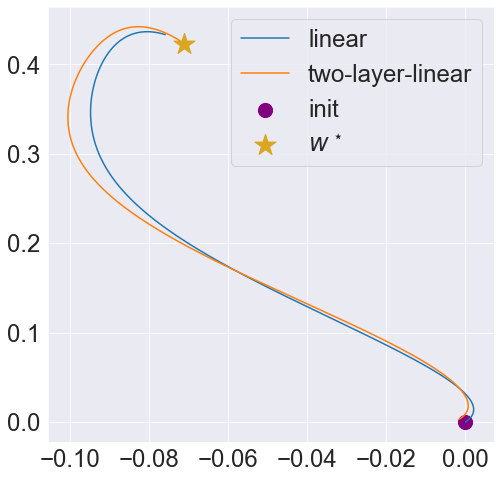

In [18]:
(k1, k2) = (0, 1)
w_star_np = w_star.detach().numpy()

figure = plt.figure(figsize=(8, 8))
plt.plot(ws_lin[:, k1], ws_lin[:, k2], linewidth=1.5, label='linear')
plt.plot(ws[:, k1], ws[:, k2], linewidth=1.5, label='two-layer-linear')
plt.scatter(ws_lin[0, k1], ws_lin[0, k2], marker='o', s=200, label='init', c='purple')
plt.scatter(w_star_np[k1], w_star_np[k2], marker='*', s=500, label='$w^\\star$', c='goldenrod')

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=24)

plt.show()

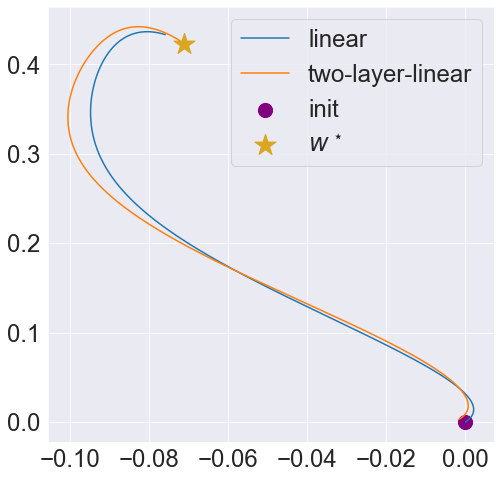

In [19]:
(k1, k2) = (0, 1)
w_star_np = w_star.detach().numpy()

figure = plt.figure(figsize=(8, 8))
plt.plot(ws_lin[:, k1], ws_lin[:, k2], linewidth=1.5, label='linear')
plt.plot(ws[:, k1], ws[:, k2], linewidth=1.5, label='two-layer-linear')
plt.scatter(ws_lin[0, k1], ws_lin[0, k2], marker='o', s=200, label='init', c='purple')
plt.scatter(w_star_np[k1], w_star_np[k2], marker='*', s=500, label='$w^\\star$', c='goldenrod')

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=24)

plt.show()

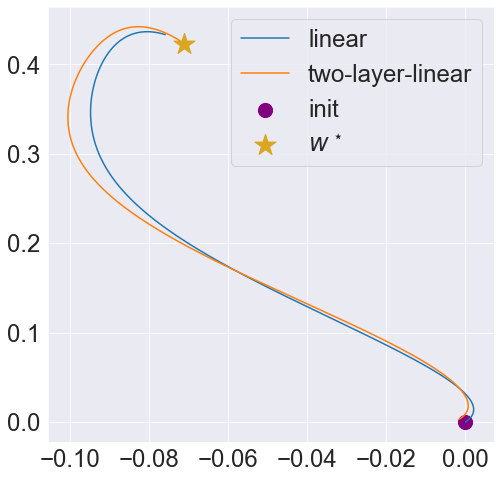

In [20]:
(k1, k2) = (0, 1)
w_star_np = w_star.detach().numpy()

figure = plt.figure(figsize=(8, 8))
plt.plot(ws_lin[:, k1], ws_lin[:, k2], linewidth=1.5, label='linear')
plt.plot(ws[:, k1], ws[:, k2], linewidth=1.5, label='two-layer-linear')
plt.scatter(ws_lin[0, k1], ws_lin[0, k2], marker='o', s=200, label='init', c='purple')
plt.scatter(w_star_np[k1], w_star_np[k2], marker='*', s=500, label='$w^\\star$', c='goldenrod')

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=24)

plt.show()

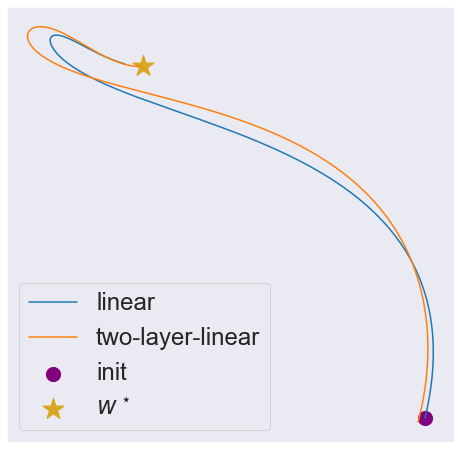

In [21]:
(k1, k2) = (0, 10)
w_star_np = w_star.detach().numpy()

figure = plt.figure(figsize=(8, 8))
plt.plot(ws_lin[:, k1], ws_lin[:, k2], linewidth=1.5, label='linear')
plt.plot(ws[:, k1], ws[:, k2], linewidth=1.5, label='two-layer-linear')
plt.scatter(ws_lin[0, k1], ws_lin[0, k2], marker='o', s=200, label='init', c='purple')
plt.scatter(w_star_np[k1], w_star_np[k2], marker='*', s=500, label='$w^\\star$', c='goldenrod')

#plt.xticks(fontsize=20)
#plt.yticks(fontsize=20)
plt.xticks([], [])
plt.yticks([], [])
plt.legend(fontsize=24)

plt.savefig(os.path.join(FIGURES_DIR, 'lin_vs_2-layer_cv.jpg'))
plt.show()

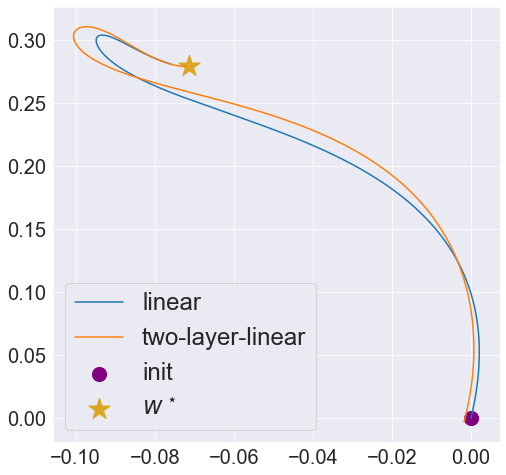

In [23]:
(k1, k2) = (0, 10)
w_star_np = w_star.detach().numpy()

figure = plt.figure(figsize=(8, 8))
plt.plot(ws_lin[:, k1], ws_lin[:, k2], linewidth=1.5, label='linear')
plt.plot(ws[:, k1], ws[:, k2], linewidth=1.5, label='two-layer-linear')
plt.scatter(ws_lin[0, k1], ws_lin[0, k2], marker='o', s=200, label='init', c='purple')
plt.scatter(w_star_np[k1], w_star_np[k2], marker='*', s=500, label='$w^\\star$', c='goldenrod')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=24)

plt.savefig(os.path.join(FIGURES_DIR, 'lin_vs_2-layer_cv.jpg'))
plt.show()

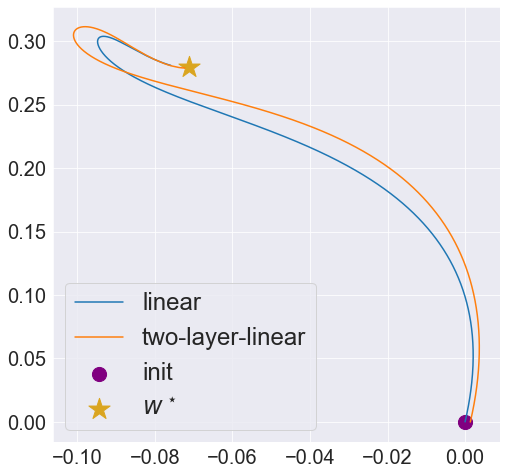

In [41]:
idx = 7
ws = training_results[idx][widths[-1]]['ws']

(k1, k2) = (0, 10)
w_star_np = w_star.detach().numpy()

figure = plt.figure(figsize=(8, 8))
plt.plot(ws_lin[:, k1], ws_lin[:, k2], linewidth=1.5, label='linear')
plt.plot(ws[:, k1], ws[:, k2], linewidth=1.5, label='two-layer-linear')
plt.scatter(ws_lin[0, k1], ws_lin[0, k2], marker='o', s=200, label='init', c='purple')
plt.scatter(w_star_np[k1], w_star_np[k2], marker='*', s=500, label='$w^\\star$', c='goldenrod')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=24)

plt.savefig(os.path.join(FIGURES_DIR, 'lin_vs_2-layer_cv.jpg'))
plt.show()

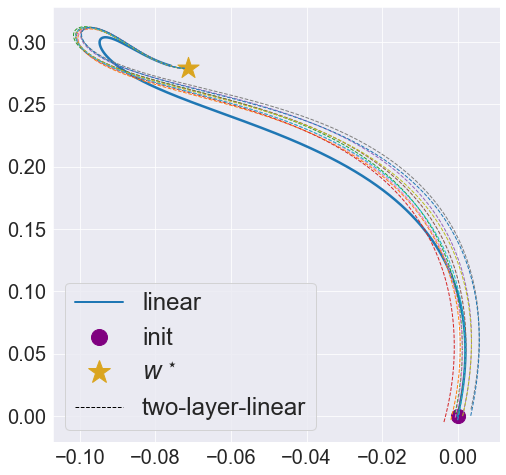

In [68]:
(k1, k2) = (0, 10)
w_star_np = w_star.detach().numpy()

legend_elements = [Line2D([0], [0], color=sns.color_palette()[0], label='linear', linewidth=2.0),
                   Line2D([], [], marker='o', label='init', linestyle='None', c='purple', markersize=16),
                   Line2D([], [], marker='*', linestyle='None', label='$w^\\star$', c='goldenrod',
                          markersize=24),
                   Line2D([0], [0], linestyle='dashed', label='two-layer-linear', c='black', linewidth=1.0)]

figure = plt.figure(figsize=(8, 8))
plt.plot(ws_lin[:, k1], ws_lin[:, k2], linewidth=2.5, label='linear')
for idx in range(n_trials):
    ws = training_results[idx][widths[-1]]['ws']
    #plt.plot(ws[:, k1], ws[:, k2], linewidth=1.5, label='two-layer-linear')
    plt.plot(ws[:, k1], ws[:, k2], linewidth=1., linestyle='dashed')
plt.scatter(ws_lin[0, k1], ws_lin[0, k2], marker='o', s=200, label='init', c='purple')
plt.scatter(w_star_np[k1], w_star_np[k2], marker='*', s=500, label='$w^\\star$', c='goldenrod')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(handles=legend_elements, fontsize=24)

plt.savefig(os.path.join(FIGURES_DIR, 'lin_vs_2-layer_cv.jpg'))
plt.show()

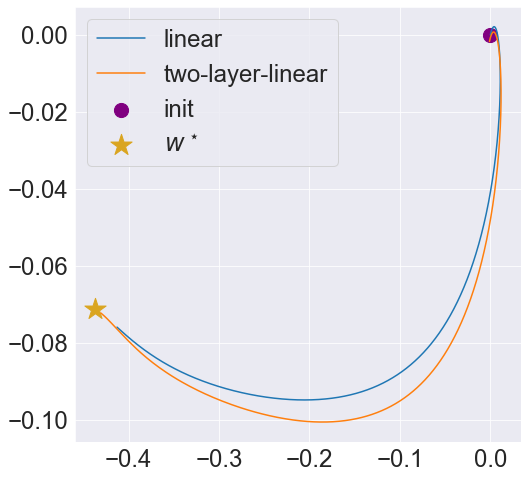

In [26]:
(k1, k2) = (2, 0)
w_star_np = w_star.detach().numpy()

figure = plt.figure(figsize=(8, 8))
plt.plot(ws_lin[:, k1], ws_lin[:, k2], linewidth=1.5, label='linear')
plt.plot(ws[:, k1], ws[:, k2], linewidth=1.5, label='two-layer-linear')
plt.scatter(ws_lin[0, k1], ws_lin[0, k2], marker='o', s=200, label='init', c='purple')
plt.scatter(w_star_np[k1], w_star_np[k2], marker='*', s=500, label='$w^\\star$', c='goldenrod')

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=24)

plt.show()

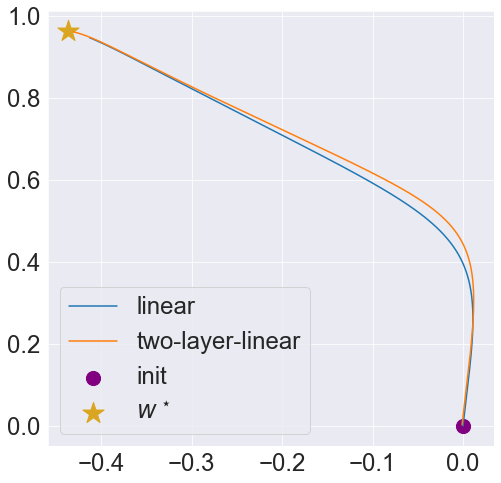

In [27]:
(k1, k2) = (2, 11)
w_star_np = w_star.detach().numpy()

figure = plt.figure(figsize=(8, 8))
plt.plot(ws_lin[:, k1], ws_lin[:, k2], linewidth=1.5, label='linear')
plt.plot(ws[:, k1], ws[:, k2], linewidth=1.5, label='two-layer-linear')
plt.scatter(ws_lin[0, k1], ws_lin[0, k2], marker='o', s=200, label='init', c='purple')
plt.scatter(w_star_np[k1], w_star_np[k2], marker='*', s=500, label='$w^\\star$', c='goldenrod')

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=24)

plt.show()

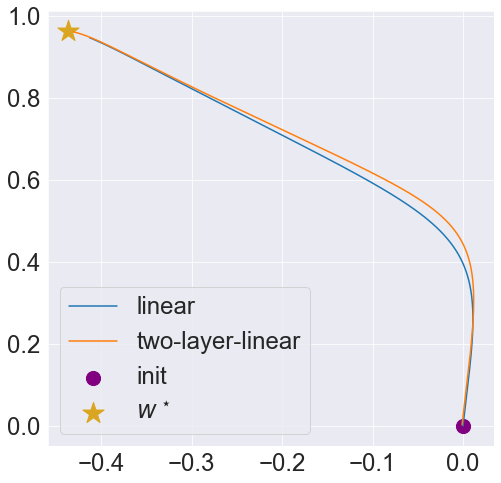

In [28]:
(k1, k2) = (2, 11)
w_star_np = w_star.detach().numpy()

figure = plt.figure(figsize=(8, 8))
plt.plot(ws_lin[:, k1], ws_lin[:, k2], linewidth=1.5, label='linear')
plt.plot(ws[:, k1], ws[:, k2], linewidth=1.5, label='two-layer-linear')
plt.scatter(ws_lin[0, k1], ws_lin[0, k2], marker='o', s=200, label='init', c='purple')
plt.scatter(w_star_np[k1], w_star_np[k2], marker='*', s=500, label='$w^\\star$', c='goldenrod')

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=24)

plt.show()